<a href="https://colab.research.google.com/github/shinhs0920/Engineering-computing-application/blob/master/SMILES_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SMILES (Simplified Molecular Input Line Entry System)


SMILES는 ASCII 문자들로 표현한 원자와 결합들을 통해 분자 및 분자간 반응들을 표현한 간단하면서 포괄적인 화학 언어이다. 사람이 이해하기 쉬우며 매우 간결하고 표준화된 경우 특정 구조 및 물질을 나타내는데 있어서 범용적으로 쓰입니다. 즉, 스마일 문자열은 분자 및 분자간 반응들을 매우 올바르고 이해하기 쉽게 표현 가능합니다.

In [0]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.8
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2019.09.2 installation finished!


In [0]:
#RDkit 적용
from __future__ import print_function #2.X대 python호환을 위해
from rdkit import Chem
from rdkit.Chem import AllChem

In [0]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

##  1. Canonicalization (정규화)
* generic SMILES : 동위원소 및 카이랄 정보가 없이 분자 그림만으로 설명
* 주어진 구조에 대해 유효한 다양한 SMILES들이 존재한다.
* unique SMILES : 수 많은 generic SMILES 중 Canonicalization을 통해 단 하나 스마일 형태로 변형된 것
* isomeric SMILES: 동위원소, 카이랄을 표현하기 위한 스마일
* absolute SMILES: 모든 구조까지 파악한 스마일, unique + isomeric SMILES

Input SMILES | Unique SMILES
---| ---|
OCC	|CCO
[CH3][CH2][OH]|	CCO
C-C-O|	CCO
C(O)C	|CCO
OC(=O)C(Br)(Cl)N|	NC(Cl)(Br)C(=O)O
ClC(Br)(N)C(=O)O|	NC(Cl)(Br)C(=O)O
O=C(O)C(N)(Br)Cl|	NC(Cl)(Br)C(=O)O


In [0]:
# Chem.MolFromSmiles('원소') Smiles언어를 이용해 파이썬에 저장한다. Chem.MolToSmiles을 통해 불러온다
m = Chem.MolFromSmiles('OCC')
Chem.MolToSmiles(Chem.MolFromSmiles('OCC'))
# OCC로 입력했지만 결과값은 자동으로 CCO로 나타난다

'CCO'

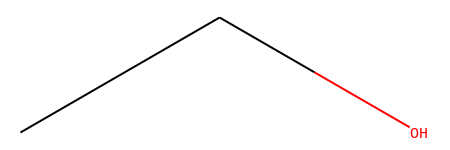

In [0]:
m

In [0]:
Chem.MolToMolBlock(m)

'\n     RDKit          2D\n\n  3  2  0  0  0  0  0  0  0  0999 V2000\n    2.5981   -0.0000    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.2990    0.7500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n  1  2  1  0\n  2  3  1  0\nM  END\n'

## 2. SMILES Specification Rules
* 스마일 표기법은 공백없이 표현합니다.
* 수소원자는 생략이 가능합니다
* 방향족 구조들은 직관적으로 명시하거나 `Kekulé form`으로 분류할 수 있다.

케쿨레 구조: 이중결합과 단일결합으로 방향족 구조물을 표현<br>
EX) 벤젠<br>
<img src="https://github.com/legi1993/seq2seq-smile/blob/master/%EB%B2%A4%EC%A0%A0%20%EA%B5%AC%EC%A1%B0.png?raw=true" width="40%">




### 2.1 Atom
* 수소를 포함하지 않는 개별원자는 [ ]를 사용한다. <br>
EX) [Li] :	Lithium
* 두 문자의 두 번쨰 원소기호는 소문자로 입력한다.
* 미지의 원자는 * 로 [ ] 없이 입력한다<br>
EX) *F : Fluorine과 미지의 원자가 결합한 형태
* 유기물집합(organic subset, B, C, N, O, P, S, F, Cl Br, I)는 [ ] 없이 쓰이면 최소 원자가 전자 수 만큼 수소가 결합했다고 여긴다. B (3), C (4), N (3,5), O (2), P (3,5), S (2,4,6), 할로겐족(1).
* 지방족 탄소는 대문자 'C' 로, 방향족 탄소는 'c'로 명시한다.

입력|이름|출력값|
:---:|:---|:---:|
C|	methane|	(CH4)
P|	phosphine	|(PH3)
N	|ammonia	|(NH3)
S	|hydrogen sulfide	|(H2S)
O|	water	|(H2O)
Cl|	hydrochloric acid	|(HCl)

* 유기물집합 혹은  최소 원자가 전자 이외에 값을 가질 경우 [ ] 사용한다.

입력값| 이름|
---|:---|
[S]|	elemental sulfur
[Au]|	elemental gold

* [ ]속의 수소와 형식전하는 반드시 명시되어야 한다. 결합된 수소의 수는 H와 숫자로 표현된다.
* 형식전하는 `+` 혹은 `-` 로 표시되어야 한다. 명시되어 있지 않으면 전하는 0으로 가정한다.


 입력값 | 이름|
 :----:|:---|
[H+]|	proton
[Fe+2]	|iron (II) cation
[OH-]|	hydroxyl anion
[Fe++]|	iron (II) cation
[OH3+]|	hydronium cation
[NH4+]|	ammonium cation



In [0]:
iron2 = Chem.MolFromSmiles('[Fe++]')
iron22 = Chem.MolFromSmiles('[Fe+2]')
methan = Chem.MolFromSmiles('C')
water = Chem.MolFromSmiles('O')
ox = Chem.MolFromSmiles('O=O')
carbon = Chem.MolFromSmiles('[C]')

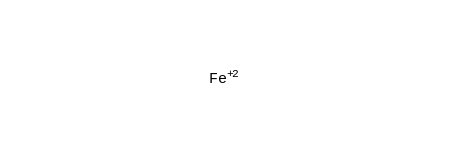

In [0]:
iron2

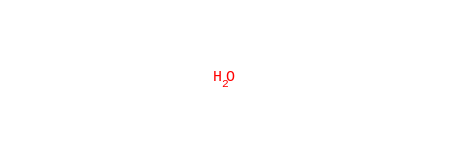

In [0]:
water

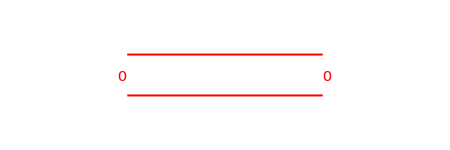

In [0]:
ox

### 2.2 Bonds
* `-` : 단일결합
* `=` : 이중결합
* `#` : 삼중결합
* `:` : 방향족 결합
* 인접 원자의 경우 단일결합, 방향족 결합은 생략 가능합니다

입력 | 이름 | 스마일
:---:|:---|:---|
CC	|ethane	|(CH3CH3)
C=O	|formaldehyde	|(CH2O)
C=C	|ethene	|(CH2=CH2)
O=C=O	|carbon dioxide|	(CO2)
COC	|dimethyl ether|	(CH3OCH3)
C#N	|hydrogen cyanide|	(HCN)
CCO|	ethanol	|(CH3CH2OH)
[H][H]|	molecular hydrogen	|(H2)



* 선형 구조의 경우 단일 결합 및 수소를 생략한다.

구조	|유효한 SMILES|
:---:|:---:|
 	                          | C = CCC = CCO
CH2 = CH-CH2-CH = CH-CH2-OH |	C = CCC = CCO
 	                          | OCC = CCC = C


In [0]:
ethane = Chem.MolFromSmiles('CC')

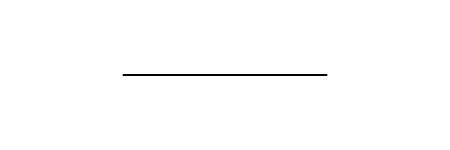

In [0]:
ethane

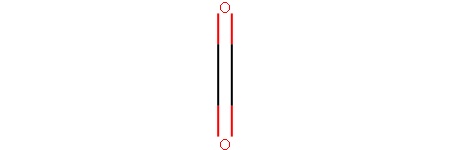

In [0]:
CO2 = Chem.MolFromSmiles('O=C=O')
CO2

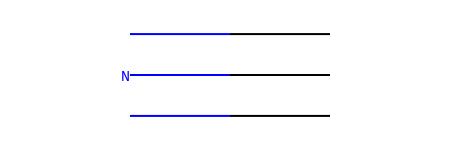

In [0]:
hcn = Chem.MolFromSmiles('C#N') ; hcn


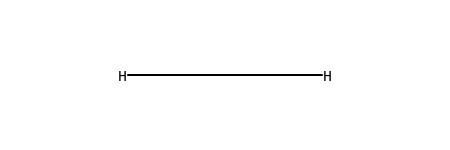

In [0]:
H2 = Chem.MolFromSmiles('[H][H]')
H2  # 수소분자의 경우엔 예외적으로 위와같이 표기한다.

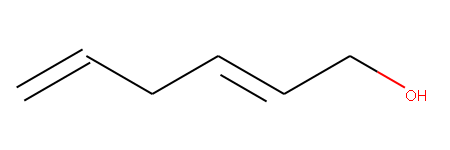

In [0]:
#Ex) 6-hydroxy-1,4-hexadiene
A1 = Chem.MolFromSmiles('C=CCC=CCO')
A1

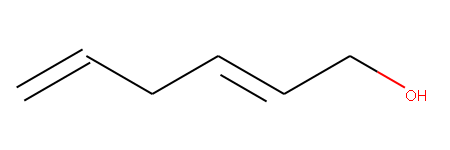

In [0]:
A2 = Chem.MolFromSmiles('C=C-C-C=C-C-O')
A2

###  2.3 Branches
* 가지들은 괄호로 묶어 지정하면 중첩되거나 쌓을 수 있습니다.
* 모든 경우에 대해 괄호에 대한 암시적 연결은 왼쪽입니다.

		

![트리에틸아민](https://www.daylight.com/dayhtml/doc/theory/theory1.gif) | ![이소부티르산](https://www.daylight.com/dayhtml/doc/theory/theory2.gif) | ![3프로필-4](https://www.daylight.com/dayhtml/doc/theory/theory3.gif)
---|---|---|
CCN (CC) CC	|CC (C) C (= O) O	|C = CC (CCC) C (C (C) C) CCC
트리 에틸 아민|	이소 부티르산	|3- 프로필 -4- 이소 프로필 -1- 헵텐


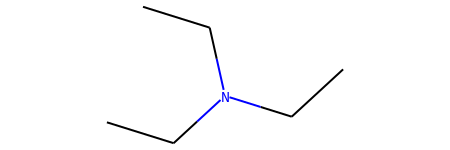

In [0]:
tea = Chem.MolFromSmiles('CCN(CC)CC') ; tea

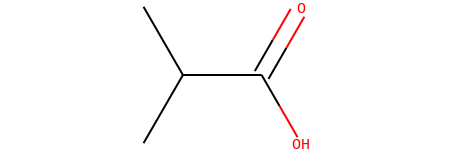

In [0]:
iba = Chem.MolFromSmiles('CC(C)C(=O)O')
iba

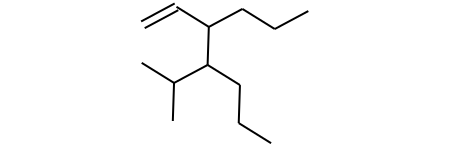

In [0]:
p4i1h = Chem.MolFromSmiles('C=CC(CCC)C(C(C)C)CCC') ; p4i1h

### 2.4 Cyclic Structures

* 고리에서 하나의 결합을 끊는 것으로 표시한다. 결합은 임의의 순서로 번호가 매겨지며, 숫자로 고리 개방(고리 폐쇄) 결합을 지정한다

> Ex)Cyclohexane <br>
![Cyclohexane](https://www.daylight.com/dayhtml/doc/theory/theory4.gif)


* 동일한 화학물을 여러 방법으로 표현할 수 있다.
* 한 가지의 분자의 다양한 표현은 우선순위가 없다.
* (a) Br을 가지로 본 경우 , (b) (CCC1)을 가지로 본 경우

>Ex)1-methyl-3-bromo-cyclohexene-1 <br>
![1-methyl-3-bromo-cyclohexene-1](http://www.daylight.com/dayhtml/doc/theory/theory5.gif)


* 한 원자는 하나 이상의 고리 개방(고리 폐쇄) 결합을 가질 수 있다.


>EX) SMILES for cubane: C12C3C4C1C5C4C3C25.<br>
![Atom with 2ring](https://www.daylight.com/dayhtml/doc/theory/theory6.gif) 



* 필요한 경우, 링 클로징을 나타내는 숫자를 재사용 할 수 있습니다

> EX)O1CCCCC1N1CCCCC1<br>
![재사용](https://www.daylight.com/dayhtml/doc/theory/theory7.gif)


* 한 번에 10 개 이상의 링 클로징을 열어야하는 경우,두 자리 숫자 이상의 경우 앞에 % 기호를 사용하여  10개 이사의 링 클로저 구조를 만들 수 있습니다. 예를 들어, C2 % 13 % 24 는 고리 폐쇄 2, 13 및 24를 갖는 탄소 원자이다.

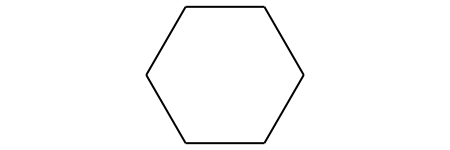

In [0]:
Cyclohexane = Chem.MolFromSmiles('C1CCCCC1')
Cyclohexane

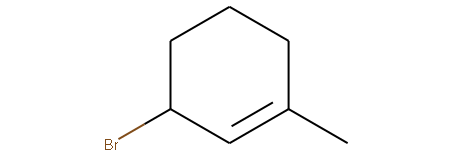

In [0]:
M1 = Chem.MolFromSmiles('CC1=CC(Br)CCC1')
M2 = Chem.MolFromSmiles('CC1=CC(CCC1)Br')
M1

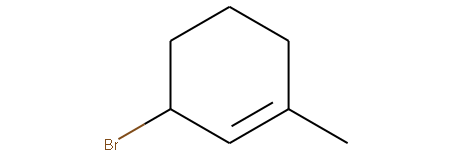

In [0]:
M2

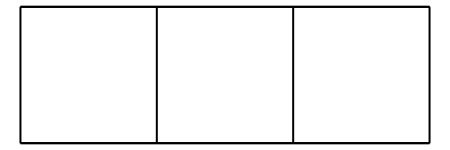

In [0]:
M3 = Chem.MolFromSmiles('C12C3C4C1C5C4C3C25')
M3

In [0]:
print(Chem.MolToSmiles(M1))
print(Chem.MolToSmiles(M2))

CC1=CC(Br)CCC1
CC1=CC(Br)CCC1


### 2.5 Disconnected Structures

* Disconnected Structures은 '.'(마침표)를 사용하여 각각의 구조들을 분리시킨다. <br>
EX) 이온, 리간드, 혼합물
* `이온` 혹은 `리간드(ligands)`의 연결은 순서에 상관없이 사용가능하다. 
* 전하끼리 반드시 연결되는 것도 아니고, 알짜 전하를 반드시 0으로 가질 필요도 없다.
* 필요에 따라, 한 이온의 SMILE이 sodium phenoxide(석탄산나트륨)와 같이 다른 이온사이에 삽입될 수 있다.
>![sodium phenoxide](https://www.daylight.com/dayhtml/doc/theory/theory8.gif)

* 원자들이 숫자쌍 사이에 나열된 것들은 결합되었다고 간주한다.
* 명시적 결합 : 결합 기호들, E/Z, 고리 닫힘 기호 <br>
  암묵적(생략가능) 결합 : 단일결합, 방향족 결합
* 점(.)으로 분리된 인접한 원자들은 원자가 서로 결합하지 않는다는 것을 의미한다. 이는 원자가 같은 화합물로 연결되어 있는지를 확인하기 위한 사실이다.<br>
EX) C1.COCC1의 의미는 이 물질은 COCCC와 같다는 의미이며 CCOCC가 아니다란 뜻이다.

In [0]:
N1 = Chem.MolFromSmiles('[Na+].[O-]c1ccccc1')
N2 = Chem.MolFromSmiles('c1cc([O-].[Na+])ccc1')
mixture = Chem.MolFromSmiles('CCO.O')
ethane = Chem.MolFromSmiles('CC')

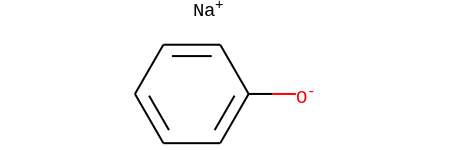

In [0]:
N1

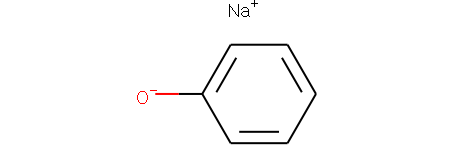

In [0]:
N2

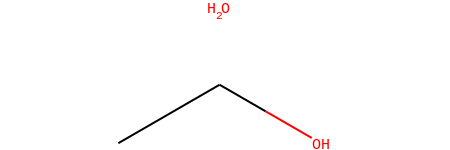

In [0]:
mixture # CCO가 물과 결합한 형태가 아닌 녹아 있는 혼합물

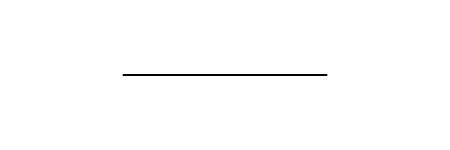

In [0]:
ethane

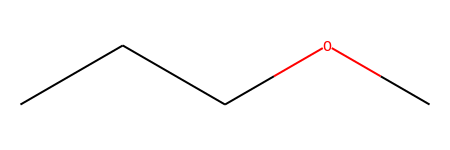

In [0]:
CdotC = Chem.MolFromSmiles('C1.COCC1') ; CdotC

##  3.Isomeric SMILES(이성질체)

* 동위 원소, 이중결합의 구조, 그리고 카이랄성을 추가적으로 규정.
* IUPAC와 CIP에서의 화학적 명명법과는 다르게 설명할 규칙들은 카이랄성의 부분적 명시를 위해 고안되었다.
* 모든 화합물의 카이랄성이 알려져 있지 않기에, 이용 가능한 카이랄성만을 표기한다.
* SMILE에서 모든 이성질체의 명시 규칙은 선택적이다. 특성의 규격이 없다는 것은 해당하는 특성의 값이 지정되지 않았음을 의미한다. 

### 3.1 Isotopic Specification(동위원소)

* 동위원소는 해당되는 원소의 원자를 `[ 원자량+원자기호 ]` 로 표기한다.

SMILES | Name
:---- | :----
$[12C]$ | carbon-12
$[13C]$ | carbon-13
$[C]$ | carbon(unspecified mass)
$[13CH4]$ | C-13 methane

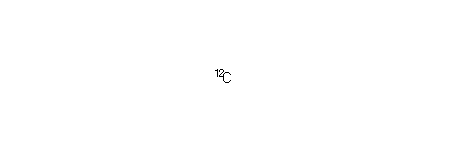

In [0]:
C12 = Chem.MolFromSmiles('[12C]')
C12

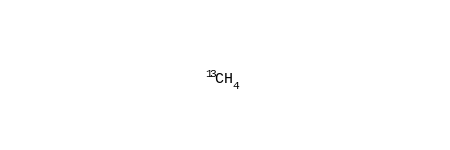

In [0]:
C13H4 =  Chem.MolFromSmiles('[13CH4]') ;C13H4

### 3.2 Configuration Around Double Bonds(이중결합의 배치)

* / or \ : tans/cis or E/Z 결합을 나타내는 기호

> **E/Z** : cis/trans 결합의 확장편, 세 개이상 다른 치환기를 가질 경우 에도 이중 결합을 잘 표현 가능하다<br>
E(독일어 entgegen) : 반대편이라는 어원, 높은 우선순위를 갖는 탄소가 포함된 치환기가 이중결합의 **반대 위치**에 존재할 경우(≒trans-)<br>
Z(독일어 zusammen) : 함께라는 어원, 높은 우선순위를 갖는 탄소가 포함된 치환기가 이중결합의 **같은 위치**에 존재할 경우(≒cis-)<br>


Ex) E- and Z-1,2-difluoroethene

![c2f2trans](https://www.daylight.com/dayhtml/doc/theory/theory9.gif)|![c2f2cis](https://www.daylight.com/dayhtml/doc/theory/theory10.gif)
---|---|
F / C = C / F	| F / C = C \ F
F \ C = C \ F	| F \ C = C / F

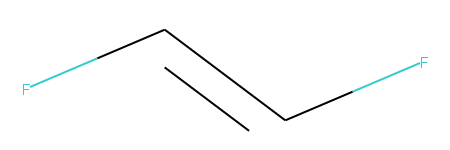

In [0]:
E1 = Chem.MolFromSmiles('F/C=C/F')
E2 = Chem.MolFromSmiles('F/C=C\F')
E1

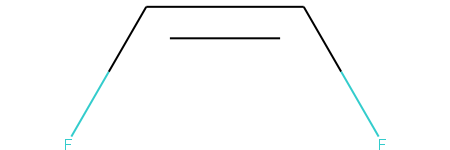

In [0]:
E2

* 전체 구조를 다 입력해주는게 좋지만 스마일은 전체 구조를 다 파악해 입력할 필요 없이 부분적으로 원소만 입력하는 것이 가능하다

completely specified | partially specified
---- | ----
![complete](http://www.daylight.com/dayhtml/doc/theory/theory11.gif) | ![partial](http://www.daylight.com/dayhtml/doc/theory/theory12.gif)
F/C=C/C=C/C | F/C=C/C=CC

In [0]:
S1 = Chem.MolFromSmiles('F/C=C/C=C/C')
S2 = Chem.MolFromSmiles('F/C=C/C=CC')

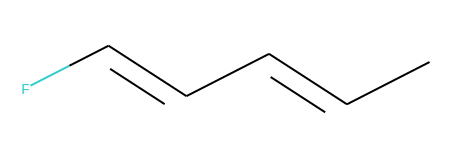

In [0]:
S1

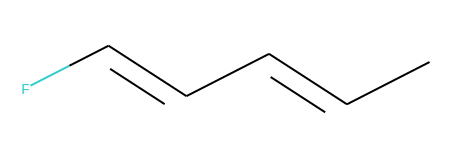

In [0]:
S2 # 부분적으로 입력해도 알아서 구조를 그려준다

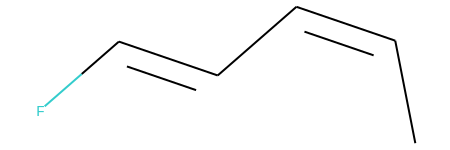

In [0]:
S3 = Chem.MolFromSmiles('F/C=C/C=C\C')
S3